## Introduction:

Credit fraud is the manipulation of unauthorized card that are stolen or theft from the cardholder. It can be the card itself or the personal details from the owner. In this kernel multiple solutions is demonstrated.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset has pre-processed with PCA transformation except Time, Amount and Class feature.

Due to confidentiality issues, there are not provided the original features and more background information about the data.

* Features V1, V2, … V28 are the principal components obtained with PCA.
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount.
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In This kernel I will be showing the steps to detect frauds.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from catboost import Pool, CatBoostClassifier, cv

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score,make_scorer,roc_auc_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input/creditcardfraud/creditcard.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Loading the Data

In [2]:
df = pd.read_csv("../input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Data Analysis

In [3]:
pd.set_option("display.float", "{:.2f}".format)
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


### Check for missing value

In [4]:
miss = df.isnull().sum()
miss_percnt = (miss/len(df))*100
pd.concat([miss,miss_percnt], axis=1, keys=['Missing Values','Missing Percentage'])

,Missing Values,Missing Percentage
Time,0,0.00
V1,0,0.00
V2,0,0.00
V3,0,0.00
V4,0,0.00
V5,0,0.00
V6,0,0.00
V7,0,0.00
V8,0,0.00
V9,0,0.00


In [5]:
print('There are 492 frauds and the rest are genuine transactions in the dataset. \n1 represents fraud and 0 represents  Genuine')
df['Class'].value_counts()

There are 492 frauds and the rest are genuine transactions in the dataset. 
1 represents fraud and 0 represents  Genuine


0    284315
1       492
Name: Class, dtype: int64

In [6]:
fraud = df[(df['Class'] != 0)]
normal = df[(df['Class'] == 0)]

trace = go.Pie(labels = ['Normal', 'Fraud'], values = df['Class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of normal and fraud tansactions')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

We can see from that pie chart, that relatively the fraud transaction is very very small. So, here is the problem arises because the high disparity of classes gives low precision and recall score. We have to choose our path wisely so that our model can detect the frauds wisely

#### Lets check how much frauds occur per hour and per minute

In [7]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_min'] = (timedelta.dt.components.minutes).astype(int)
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

In [8]:
class_0 = df.loc[df['Class'] == 0]["Time_hour"]
class_1 = df.loc[df['Class'] == 1]["Time_hour"]
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time/Hour Density Plot', xaxis=dict(title='Time [Hr]'))
py.iplot(fig, filename='dist_only_Hr')

In [9]:
class_0 = df.loc[df['Class'] == 0]["Time_min"]
class_1 = df.loc[df['Class'] == 1]["Time_min"]
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time/Hour Density Plot', xaxis=dict(title='Time [Min]'))
py.iplot(fig, filename='dist_only_min')

### Distribution of Time and Amount

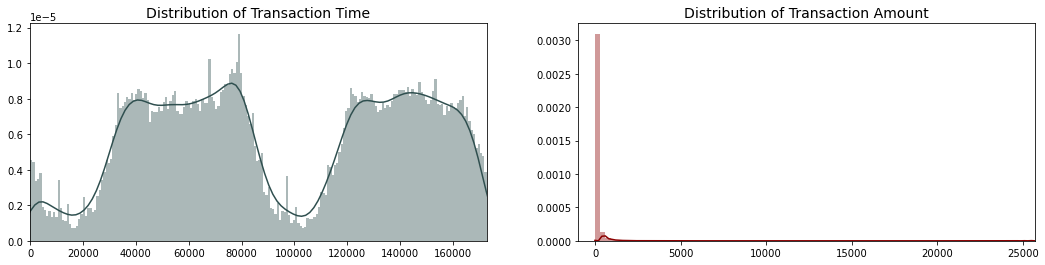

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(time_val, ax=ax[0], bins=200, color='darkslategray')
ax[0].set_title('Distribution of Transaction Time', fontsize=14)
ax[0].set_xlim([min(time_val), max(time_val)])

sns.distplot(amount_val, ax=ax[1], bins=85, color='darkred')
ax[1].set_title('Distribution of Transaction Amount', fontsize=14)
ax[1].set_xlim([min(amount_val - 1000), max(amount_val)])

plt.show()

### Distribution of Fraud and Genuine Transactions

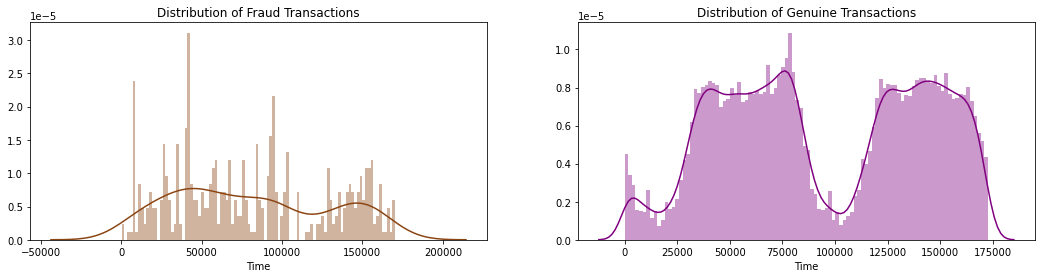

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(18,4))

sns.distplot(df[(df['Class'] == 1)]['Time'], bins=100, color='saddlebrown', ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.distplot(df[(df['Class'] == 0)]['Time'], bins=100, color='purple', ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")

plt.show()

### Amount of transactions according to time

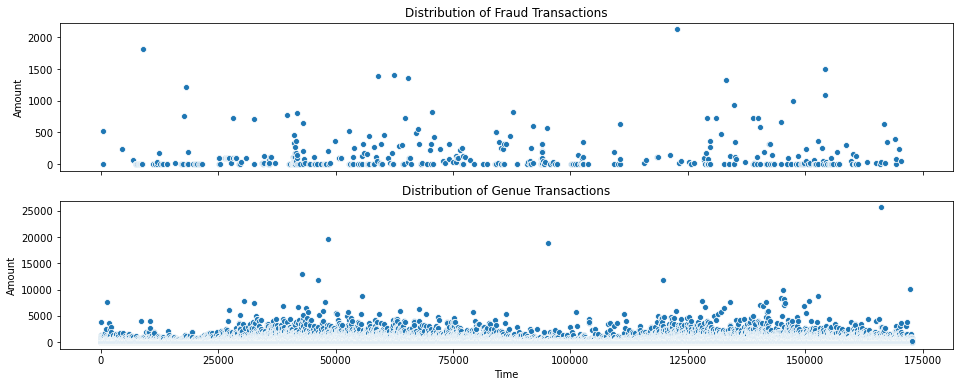

In [12]:
fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(16,6))

sns.scatterplot(x='Time',y='Amount', data=df[df['Class']==1], ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.scatterplot(x='Time',y='Amount', data=df[df['Class']==0], ax=axs[1])
axs[1].set_title("Distribution of Genue Transactions")

plt.show()

### Both Transactions Relative to Time

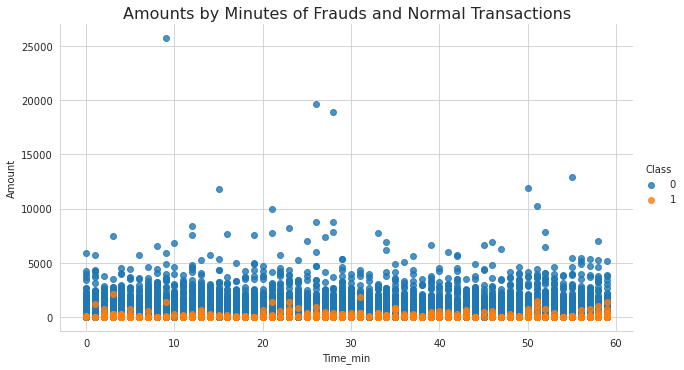

In [13]:
sns.set_style('whitegrid')
ax = sns.lmplot(y="Amount", x="Time_min", fit_reg=False,aspect=1.8,
                data=df, hue='Class')
plt.title("Amounts by Minutes of Frauds and Normal Transactions",fontsize=16)
plt.show()

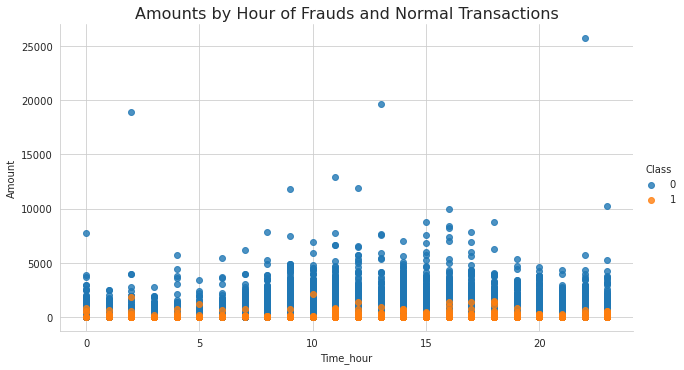

In [14]:
ax = sns.lmplot(y="Amount", x="Time_hour", fit_reg=False,aspect=1.8,
                data=df, hue='Class')
plt.title("Amounts by Hour of Frauds and Normal Transactions", fontsize=16)

plt.show()
df.drop(['Time_hour', 'Time_min'], axis=1, inplace=True)

### Distribuiton of Amount vs Class

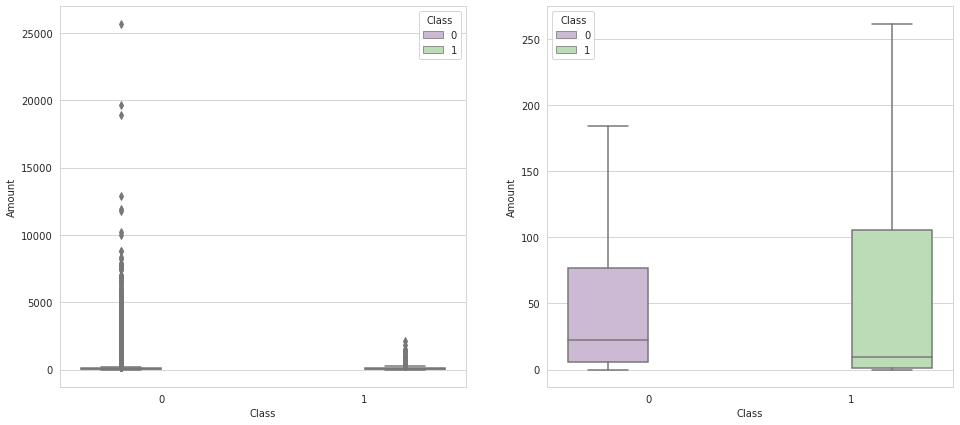

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,7))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

### Density Plots of all Features

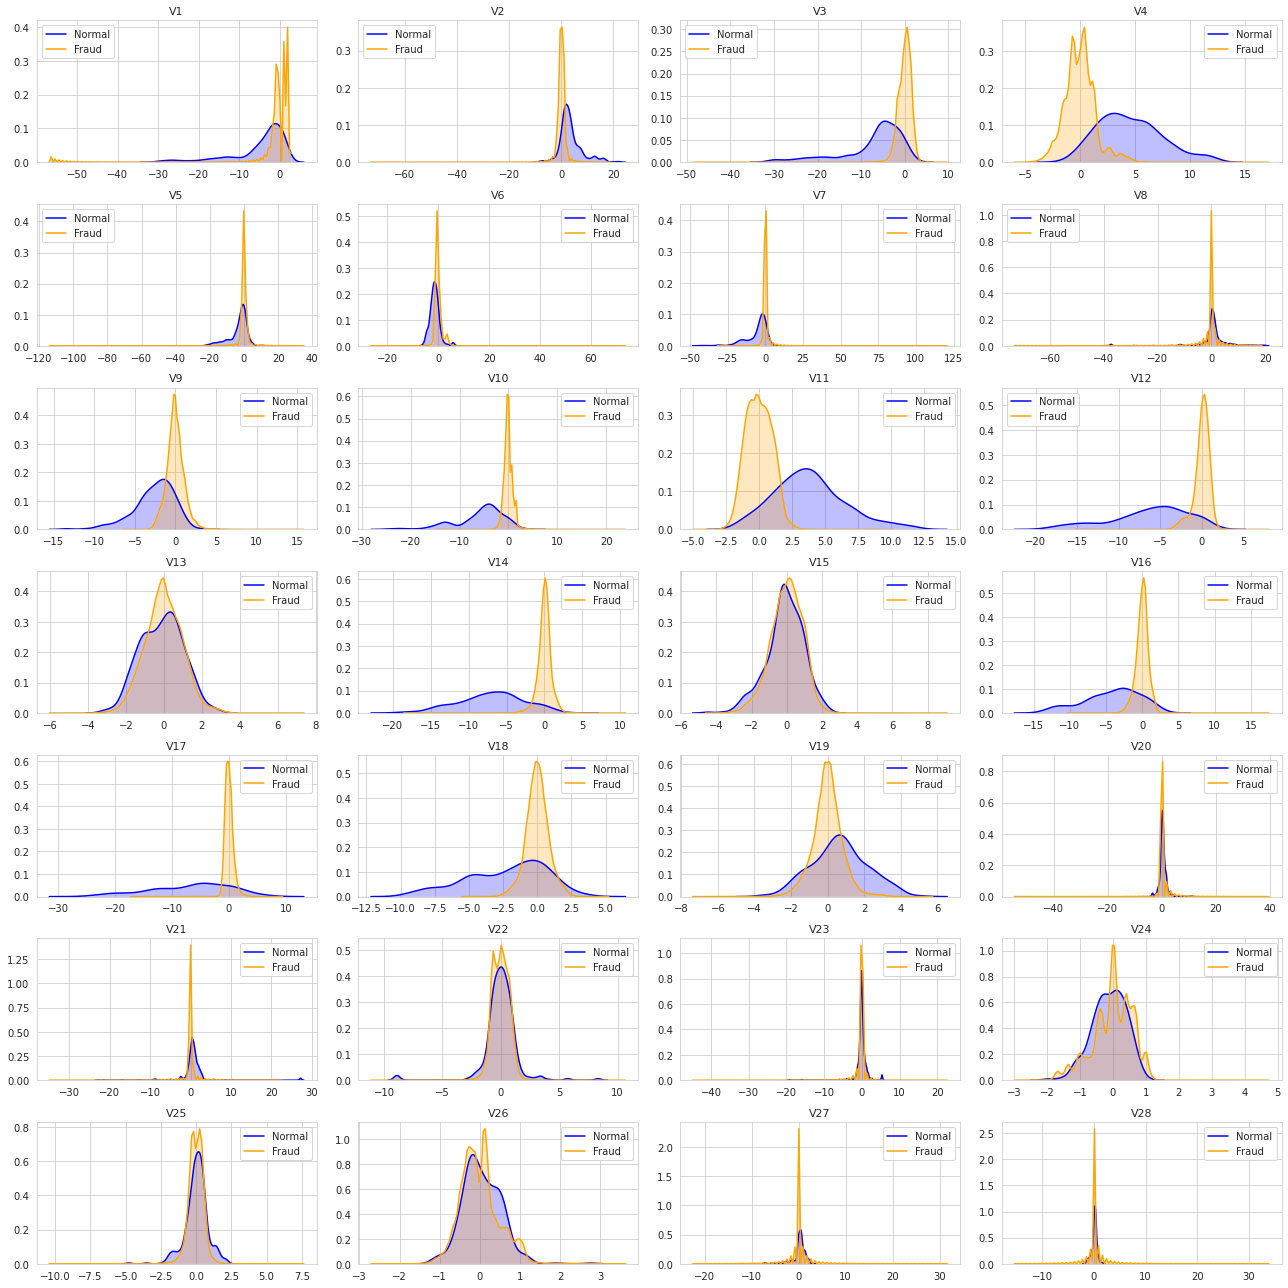

In [16]:
# cols plot  
cols_names = df.drop(['Class', 'Amount', 'Time'], axis=1)
idx = 0

# Spliting classes
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

# figure plot  
fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

for col in cols_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(fraud[col], label="Normal", color='blue', shade=True)
    sns.kdeplot(normal[col], label="Fraud", color='orange', shade=True)
    plt.title(col, fontsize=11)
    plt.tight_layout()

## Correlation Matrix

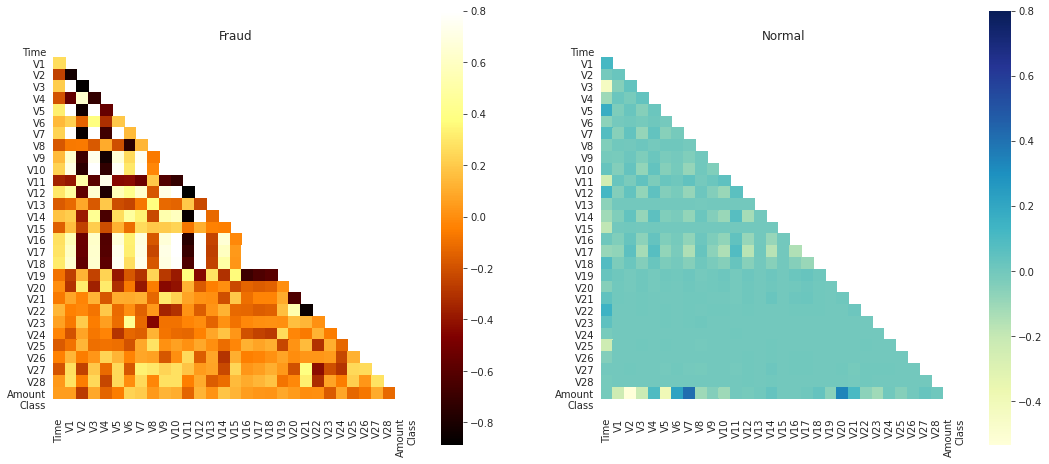

In [17]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((df.loc[df['Class'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'afmhot', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((df.loc[df['Class'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

## Scaling and Splitting the data

In [3]:
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

target = ['Class']
feat_cols = ['scaled_time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount']

In [4]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
  X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

sss2 = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
for train_idx, test_idx in sss2.split(X_train_full, y_train_full):
  X_train, X_valid = X_train_full.iloc[train_idx], X_train_full.iloc[test_idx]
  y_train, y_valid = y_train_full.iloc[train_idx], y_train_full.iloc[test_idx]

In [20]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (159491, 30)
y_train shape:  (159491,)
X_test shape:  (56962, 30)
y_test shape:  (56962,)


Lets try some models and see how they can predict the frauds.

We should not be happy for high accuracy of test set. If the precision/recall score is low then there is grave problem in the model.

1. Low precision and high recall means the model detects most of the features as fraud including the genuine transactions.
2. High precision and low recall means the model precisely detects the non-fruads but labels the frauds as genuine too.

By considering these issues, We have to build a model that can have highly balanced precision-recall/ f1 score, for that we have to check beyond accuracy score.

## Naive Bayes

In [21]:
## Naive Bayes

Model = GaussianNB()
Model.fit(X_train[feat_cols], y_train)
y_pred = Model.predict(X_test[feat_cols])

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score

print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.81      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.89      0.55     56962
weighted avg       1.00      0.98      0.99     56962

[[55578  1286]
 [   19    79]]
accuracy is 0.9770899898177733


## LightGBM

In [22]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'binary', 
             "eval_set" : [(X_test[feat_cols].values, y_test)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.001, 0.005, 0.03, 0.05, 0.1],
              'n_estimators' : [100, 300, 500, 800, 1000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e2],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 5, 7, 10],
              'reg_lambda': [0, 1e-1, 1, 5, 10]}

#number of combinations
n_iter = 5 #(replace 2 by 200, 90 minutes)

#intialize lgbm and lunch the search
lgbm_clf = lgb.LGBMClassifier(random_state=42, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=4, n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=True)

grid_search.fit(X_train[feat_cols].values, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

clf_sw = lgb.LGBMClassifier(**lgbm_clf.get_params())
#Optimal parameter
clf_sw.set_params(**opt_parameters)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


Best score reached: 0.9995799138752799 with params: {'colsample_bytree': 0.6247240713084175, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 206, 'min_child_weight': 1, 'n_estimators': 1000, 'num_leaves': 44, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.27997993265440235} 


LGBMClassifier(colsample_bytree=0.6247240713084175, max_depth=6, metric='None',
               min_child_samples=206, min_child_weight=1, n_estimators=1000,
               n_jobs=4, num_leaves=44, random_state=42, reg_alpha=0.1,
               reg_lambda=1, subsample=0.27997993265440235)

In [23]:
lgbm_clf = lgb.LGBMClassifier(colsample_bytree=0.6247240713084175, max_depth=6, metric='None',
               min_child_samples=206, min_child_weight=1, n_estimators=1000,
               n_jobs=4, num_leaves=44, random_state=42, reg_alpha=0.1,
               reg_lambda=1, subsample=0.27997993265440235)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## Random Forest

In [27]:

clf = RandomForestClassifier(max_depth=5, min_samples_split=5,min_samples_leaf=4, random_state=42)
                            
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score

print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.65      0.75        98

    accuracy                           1.00     56962
   macro avg       0.94      0.83      0.88     56962
weighted avg       1.00      1.00      1.00     56962

[[56856     8]
 [   34    64]]
accuracy is 0.9992626663389628


## Catboost

In [19]:
Model=CatBoostClassifier(eval_metric='Accuracy',use_best_model=True,random_seed=42,task_type='GPU')
Model.fit(X_train[feat_cols],y_train,eval_set=(X_test[feat_cols],y_test))

Learning rate set to 0.046269
0:	learn: 0.9992351	test: 0.9989818	best: 0.9989818 (0)	total: 10.4ms	remaining: 10.4s
1:	learn: 0.9992790	test: 0.9991047	best: 0.9991047 (1)	total: 19.8ms	remaining: 9.87s
2:	learn: 0.9994044	test: 0.9991047	best: 0.9991047 (1)	total: 28.6ms	remaining: 9.51s
3:	learn: 0.9994232	test: 0.9991398	best: 0.9991398 (3)	total: 38ms	remaining: 9.45s
4:	learn: 0.9994294	test: 0.9991749	best: 0.9991749 (4)	total: 46.8ms	remaining: 9.31s
5:	learn: 0.9994357	test: 0.9992100	best: 0.9992100 (5)	total: 55.8ms	remaining: 9.24s
6:	learn: 0.9994294	test: 0.9992100	best: 0.9992100 (5)	total: 64.6ms	remaining: 9.17s
7:	learn: 0.9994357	test: 0.9991749	best: 0.9992100 (5)	total: 73.4ms	remaining: 9.11s
8:	learn: 0.9994545	test: 0.9992100	best: 0.9992100 (5)	total: 82.3ms	remaining: 9.06s
9:	learn: 0.9994608	test: 0.9992276	best: 0.9992276 (9)	total: 91.3ms	remaining: 9.04s
10:	learn: 0.9994608	test: 0.9992100	best: 0.9992276 (9)	total: 104ms	remaining: 9.33s
11:	learn: 0.99

100:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 917ms	remaining: 8.16s
101:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 926ms	remaining: 8.15s
102:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 935ms	remaining: 8.14s
103:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 943ms	remaining: 8.13s
104:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 952ms	remaining: 8.12s
105:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 961ms	remaining: 8.11s
106:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 970ms	remaining: 8.1s
107:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 979ms	remaining: 8.09s
108:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 988ms	remaining: 8.08s
109:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 997ms	remaining: 8.06s
110:	learn: 0.9996802	test: 0.9994558	best: 0.9994558 (95)	total: 1s	remaining: 8.05s
111:	learn: 0.9996865	tes

192:	learn: 0.9997367	test: 0.9994909	best: 0.9994909 (182)	total: 1.73s	remaining: 7.25s
193:	learn: 0.9997367	test: 0.9994909	best: 0.9994909 (182)	total: 1.74s	remaining: 7.24s
194:	learn: 0.9997367	test: 0.9994909	best: 0.9994909 (182)	total: 1.75s	remaining: 7.22s
195:	learn: 0.9997367	test: 0.9994909	best: 0.9994909 (182)	total: 1.76s	remaining: 7.21s
196:	learn: 0.9997367	test: 0.9994909	best: 0.9994909 (182)	total: 1.77s	remaining: 7.21s
197:	learn: 0.9997429	test: 0.9994909	best: 0.9994909 (182)	total: 1.78s	remaining: 7.2s
198:	learn: 0.9997429	test: 0.9994909	best: 0.9994909 (182)	total: 1.78s	remaining: 7.19s
199:	learn: 0.9997429	test: 0.9994909	best: 0.9994909 (182)	total: 1.79s	remaining: 7.18s
200:	learn: 0.9997429	test: 0.9994909	best: 0.9994909 (182)	total: 1.8s	remaining: 7.17s
201:	learn: 0.9997429	test: 0.9994909	best: 0.9994909 (182)	total: 1.81s	remaining: 7.16s
202:	learn: 0.9997429	test: 0.9994909	best: 0.9994909 (182)	total: 1.82s	remaining: 7.15s
203:	learn: 

302:	learn: 0.9997868	test: 0.9995084	best: 0.9995084 (300)	total: 2.71s	remaining: 6.24s
303:	learn: 0.9997868	test: 0.9995084	best: 0.9995084 (300)	total: 2.72s	remaining: 6.24s
304:	learn: 0.9997868	test: 0.9995084	best: 0.9995084 (300)	total: 2.73s	remaining: 6.23s
305:	learn: 0.9997868	test: 0.9994909	best: 0.9995084 (300)	total: 2.74s	remaining: 6.22s
306:	learn: 0.9997868	test: 0.9994909	best: 0.9995084 (300)	total: 2.75s	remaining: 6.21s
307:	learn: 0.9997868	test: 0.9994909	best: 0.9995084 (300)	total: 2.76s	remaining: 6.2s
308:	learn: 0.9997931	test: 0.9994909	best: 0.9995084 (300)	total: 2.77s	remaining: 6.19s
309:	learn: 0.9997931	test: 0.9994909	best: 0.9995084 (300)	total: 2.78s	remaining: 6.18s
310:	learn: 0.9997931	test: 0.9994909	best: 0.9995084 (300)	total: 2.79s	remaining: 6.17s
311:	learn: 0.9997931	test: 0.9994909	best: 0.9995084 (300)	total: 2.79s	remaining: 6.16s
312:	learn: 0.9997931	test: 0.9994909	best: 0.9995084 (300)	total: 2.8s	remaining: 6.15s
313:	learn: 

415:	learn: 0.9998244	test: 0.9994909	best: 0.9995084 (300)	total: 3.74s	remaining: 5.25s
416:	learn: 0.9998244	test: 0.9994909	best: 0.9995084 (300)	total: 3.75s	remaining: 5.24s
417:	learn: 0.9998244	test: 0.9994909	best: 0.9995084 (300)	total: 3.75s	remaining: 5.23s
418:	learn: 0.9998244	test: 0.9994909	best: 0.9995084 (300)	total: 3.76s	remaining: 5.22s
419:	learn: 0.9998244	test: 0.9994733	best: 0.9995084 (300)	total: 3.77s	remaining: 5.21s
420:	learn: 0.9998244	test: 0.9994733	best: 0.9995084 (300)	total: 3.78s	remaining: 5.2s
421:	learn: 0.9998244	test: 0.9994733	best: 0.9995084 (300)	total: 3.79s	remaining: 5.19s
422:	learn: 0.9998244	test: 0.9994733	best: 0.9995084 (300)	total: 3.8s	remaining: 5.18s
423:	learn: 0.9998244	test: 0.9994909	best: 0.9995084 (300)	total: 3.81s	remaining: 5.17s
424:	learn: 0.9998244	test: 0.9994909	best: 0.9995084 (300)	total: 3.81s	remaining: 5.16s
425:	learn: 0.9998244	test: 0.9994733	best: 0.9995084 (300)	total: 3.82s	remaining: 5.15s
426:	learn: 

526:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.76s	remaining: 4.28s
527:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.77s	remaining: 4.27s
528:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.78s	remaining: 4.26s
529:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.79s	remaining: 4.25s
530:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.8s	remaining: 4.24s
531:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.81s	remaining: 4.23s
532:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.82s	remaining: 4.22s
533:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.83s	remaining: 4.21s
534:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.84s	remaining: 4.2s
535:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.85s	remaining: 4.2s
536:	learn: 0.9998433	test: 0.9994909	best: 0.9995084 (300)	total: 4.86s	remaining: 4.19s
537:	learn: 0

623:	learn: 0.9999122	test: 0.9994909	best: 0.9995084 (300)	total: 6.01s	remaining: 3.62s
624:	learn: 0.9999122	test: 0.9994909	best: 0.9995084 (300)	total: 6.03s	remaining: 3.62s
625:	learn: 0.9999185	test: 0.9994909	best: 0.9995084 (300)	total: 6.04s	remaining: 3.61s
626:	learn: 0.9999185	test: 0.9994909	best: 0.9995084 (300)	total: 6.05s	remaining: 3.6s
627:	learn: 0.9999185	test: 0.9994909	best: 0.9995084 (300)	total: 6.06s	remaining: 3.59s
628:	learn: 0.9999185	test: 0.9994909	best: 0.9995084 (300)	total: 6.08s	remaining: 3.59s
629:	learn: 0.9999185	test: 0.9994909	best: 0.9995084 (300)	total: 6.1s	remaining: 3.58s
630:	learn: 0.9999185	test: 0.9995084	best: 0.9995084 (300)	total: 6.12s	remaining: 3.58s
631:	learn: 0.9999185	test: 0.9994909	best: 0.9995084 (300)	total: 6.14s	remaining: 3.57s
632:	learn: 0.9999185	test: 0.9994909	best: 0.9995084 (300)	total: 6.15s	remaining: 3.57s
633:	learn: 0.9999185	test: 0.9994909	best: 0.9995084 (300)	total: 6.17s	remaining: 3.56s
634:	learn: 

719:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.05s	remaining: 2.74s
720:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.06s	remaining: 2.73s
721:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.07s	remaining: 2.72s
722:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.08s	remaining: 2.71s
723:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.08s	remaining: 2.7s
724:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.09s	remaining: 2.69s
725:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.1s	remaining: 2.68s
726:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.11s	remaining: 2.67s
727:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.12s	remaining: 2.66s
728:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.13s	remaining: 2.65s
729:	learn: 0.9999310	test: 0.9994909	best: 0.9995084 (300)	total: 7.14s	remaining: 2.64s
730:	learn: 

831:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.07s	remaining: 1.63s
832:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.07s	remaining: 1.62s
833:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.08s	remaining: 1.61s
834:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.09s	remaining: 1.6s
835:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.1s	remaining: 1.59s
836:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.11s	remaining: 1.58s
837:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.12s	remaining: 1.57s
838:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.13s	remaining: 1.56s
839:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.14s	remaining: 1.55s
840:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.15s	remaining: 1.54s
841:	learn: 0.9999498	test: 0.9994909	best: 0.9995084 (300)	total: 8.15s	remaining: 1.53s
842:	learn: 

940:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.09s	remaining: 570ms
941:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.1s	remaining: 560ms
942:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.11s	remaining: 551ms
943:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.12s	remaining: 541ms
944:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.13s	remaining: 531ms
945:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.13s	remaining: 521ms
946:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.14s	remaining: 512ms
947:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.15s	remaining: 502ms
948:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.16s	remaining: 492ms
949:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.17s	remaining: 483ms
950:	learn: 0.9999875	test: 0.9994909	best: 0.9995084 (300)	total: 9.18s	remaining: 473ms
951:	learn:

In [20]:
## CatBoost
y_pred=Model.predict(X_test[feat_cols])
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))
#Accuracy Score
print('accuracy is ',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56861    25]
 [    3    73]]
accuracy is  0.9995084442259752


## Feature Importance

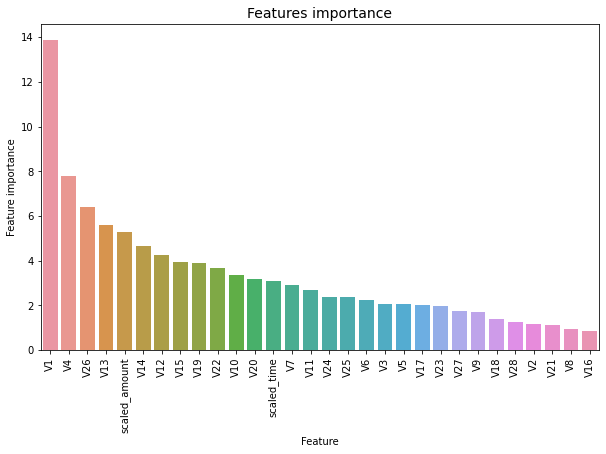

In [21]:
tmp = pd.DataFrame({'Feature': feat_cols, 'Feature importance': Model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (10,6))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

## XGBoost

In [8]:

params = {
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['binary:logistic'],
    }

clf = xgb.XGBClassifier(random_state=42, tree_method='gpu_hist')
model = GridSearchCV(estimator=clf, param_grid=params, cv=3, n_jobs=-1)
model.fit(X_train[feat_cols].values, y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method='gpu_hist',
                                     validate_parameters=None, verbosity=Non

In [9]:
y_pred=model.predict(X_test[feat_cols].values)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))
#Accuracy Score
print('accuracy is ',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.73      0.82        98

    accuracy                           1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56859    26]
 [    5    72]]
accuracy is  0.9994557775359011


Excluding Naive Bayes, all the models have showed promising accuracy, precision, recall, f1-score. Now, for that unbalanced problem in the dataset there is a solution, we can use undersampling or oversampling method and there is library for that. Next we will use imblearn's ADASYN over-sampler to solve the unbalance problem.

## Using Over-Sampling (ADASYN) Method

In [5]:
from imblearn.over_sampling import ADASYN

ads = ADASYN( random_state=42)

X_ads, y_ads = ads.fit_resample(X_train_full[feat_cols].values, y_train_full)

In [6]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X_ads, y_ads):
  X_train_ads, X_valid_ads = X_ads[train_index], X_ads[test_index]
  y_train_ads, y_valid_ads = y_ads[train_index], y_ads[test_index]

## Naive Bayes

In [30]:
## Naive Bayes

Model = GaussianNB()
Model.fit(X_train_ads, y_train_ads)
y_pred = Model.predict(X_test[feat_cols])

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score

print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.90      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.96      0.98     56962

[[54491  2373]
 [   10    88]]
accuracy is 0.9581650925178189


## XGBoost

In [12]:
params = {
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['binary:logistic']
    }

clf = xgb.XGBClassifier(random_state=42, tree_method='gpu_hist')
model = GridSearchCV(estimator=clf, param_grid=params, cv=3, n_jobs=-1)
model.fit(X_train_ads, y_train_ads)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method='gpu_hist',
                                     validate_parameters=None, verbosity=Non

In [13]:
y_pred=model.predict(X_test[feat_cols].values)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))
#Accuracy Score
print('accuracy is ',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.84      0.79        98

    accuracy                           1.00     56962
   macro avg       0.87      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962

[[56836    16]
 [   28    82]]
accuracy is  0.9992275552122467


## Random Forest

In [33]:

clf = RandomForestClassifier(max_depth=3, min_samples_split=4,min_samples_leaf=4, random_state=42)
clf.fit(X_train_ads, y_train_ads)

y_pred = clf.predict(X_test)
# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score

print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.00      0.03      0.00        98

    accuracy                           0.96     56962
   macro avg       0.50      0.50      0.49     56962
weighted avg       1.00      0.96      0.98     56962

[[54729  2135]
 [   95     3]]
accuracy is 0.9608510937115972


0% precision and 3% recall is not acceptable.

## LightGBM

In [14]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
fit_params = {"early_stopping_rounds" : 50,
             "eval_metric" : 'binary', 
             "eval_set" : [(X_valid[feat_cols].values, y_valid)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.001, 0.005, 0.03, 0.05, 0.1],
              'n_estimators' : [100, 300, 500, 800],
              'num_leaves': sp_randint(6, 40),
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1e2],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [ 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1, 5, 7, 10],
              'reg_lambda': [0, 1, 5, 10]}

#number of combinations
n_iter = 4 #(replace 2 by 200, 90 minutes)

#intialize lgbm and lunch the search
lgbm_clf = lgb.LGBMClassifier(random_state=42, silent=True, metric='None')
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    scoring='accuracy',
    cv=4, n_jobs=-1)

grid_search.fit(X_train_ads, y_train_ads, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

clf_sw = lgb.LGBMClassifier(**lgbm_clf.get_params())
#Optimal parameter
clf_sw.set_params(**opt_parameters)

Best score reached: 0.9997554515079574 with params: {'colsample_bytree': 0.5339868613881635, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 0.1, 'n_estimators': 800, 'num_leaves': 36, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9901662910177844} 


LGBMClassifier(colsample_bytree=0.5339868613881635, learning_rate=0.05,
               max_depth=7, metric='None', min_child_weight=0.1,
               n_estimators=800, num_leaves=36, random_state=42, reg_alpha=0,
               reg_lambda=1, subsample=0.9901662910177844)

In [18]:
lgbm_clf = lgb.LGBMClassifier(colsample_bytree=0.5339868613881635, learning_rate=0.05,
               max_depth=7, metric='None', min_child_weight=0.1,
               n_estimators=800, num_leaves=36, random_state=42, reg_alpha=0,
               reg_lambda=1, subsample=0.9901662910177844)

lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.76      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## Catboost

In [16]:
Model=CatBoostClassifier(eval_metric='Accuracy',use_best_model=True,random_seed=42, task_type='GPU')
Model.fit(X_train_ads,y_train_ads,eval_set=(X_valid_ads,y_valid_ads))

Learning rate set to 0.043136
0:	learn: 0.8842351	test: 0.8851459	best: 0.8851459 (0)	total: 12.4ms	remaining: 12.4s
1:	learn: 0.9029774	test: 0.9033687	best: 0.9033687 (1)	total: 23.2ms	remaining: 11.6s
2:	learn: 0.9106711	test: 0.9111612	best: 0.9111612 (2)	total: 33.7ms	remaining: 11.2s
3:	learn: 0.9151417	test: 0.9157334	best: 0.9157334 (3)	total: 44.3ms	remaining: 11s
4:	learn: 0.9188786	test: 0.9184371	best: 0.9184371 (4)	total: 55ms	remaining: 10.9s
5:	learn: 0.9212801	test: 0.9209540	best: 0.9209540 (5)	total: 65.6ms	remaining: 10.9s
6:	learn: 0.9210356	test: 0.9208990	best: 0.9209540 (5)	total: 76.3ms	remaining: 10.8s
7:	learn: 0.9193155	test: 0.9194263	best: 0.9209540 (5)	total: 87ms	remaining: 10.8s
8:	learn: 0.9205822	test: 0.9204814	best: 0.9209540 (5)	total: 101ms	remaining: 11.1s
9:	learn: 0.9240856	test: 0.9238446	best: 0.9238446 (9)	total: 111ms	remaining: 11s
10:	learn: 0.9255858	test: 0.9257240	best: 0.9257240 (10)	total: 122ms	remaining: 11s
11:	learn: 0.9279379	tes

101:	learn: 0.9898059	test: 0.9894268	best: 0.9894268 (101)	total: 1.11s	remaining: 9.8s
102:	learn: 0.9899350	test: 0.9894818	best: 0.9894818 (102)	total: 1.12s	remaining: 9.79s
103:	learn: 0.9901136	test: 0.9896686	best: 0.9896686 (103)	total: 1.13s	remaining: 9.78s
104:	learn: 0.9902236	test: 0.9897895	best: 0.9897895 (104)	total: 1.15s	remaining: 9.77s
105:	learn: 0.9905890	test: 0.9900093	best: 0.9900093 (105)	total: 1.16s	remaining: 9.75s
106:	learn: 0.9906357	test: 0.9900643	best: 0.9900643 (106)	total: 1.17s	remaining: 9.74s
107:	learn: 0.9908198	test: 0.9903171	best: 0.9903171 (107)	total: 1.18s	remaining: 9.73s
108:	learn: 0.9908885	test: 0.9904380	best: 0.9904380 (108)	total: 1.19s	remaining: 9.71s
109:	learn: 0.9911990	test: 0.9906688	best: 0.9906688 (109)	total: 1.2s	remaining: 9.7s
110:	learn: 0.9912979	test: 0.9907897	best: 0.9907897 (110)	total: 1.21s	remaining: 9.69s
111:	learn: 0.9913089	test: 0.9908886	best: 0.9908886 (111)	total: 1.22s	remaining: 9.67s
112:	learn: 0

196:	learn: 0.9967742	test: 0.9963950	best: 0.9963950 (195)	total: 2.13s	remaining: 8.67s
197:	learn: 0.9967989	test: 0.9964390	best: 0.9964390 (197)	total: 2.14s	remaining: 8.66s
198:	learn: 0.9968346	test: 0.9964390	best: 0.9964390 (197)	total: 2.15s	remaining: 8.65s
199:	learn: 0.9968483	test: 0.9964610	best: 0.9964610 (199)	total: 2.16s	remaining: 8.64s
200:	learn: 0.9968593	test: 0.9964829	best: 0.9964829 (200)	total: 2.17s	remaining: 8.63s
201:	learn: 0.9968813	test: 0.9965159	best: 0.9965159 (201)	total: 2.18s	remaining: 8.62s
202:	learn: 0.9968896	test: 0.9965049	best: 0.9965159 (201)	total: 2.19s	remaining: 8.6s
203:	learn: 0.9969088	test: 0.9965049	best: 0.9965159 (201)	total: 2.2s	remaining: 8.59s
204:	learn: 0.9969170	test: 0.9964939	best: 0.9965159 (201)	total: 2.21s	remaining: 8.58s
205:	learn: 0.9969445	test: 0.9965269	best: 0.9965269 (205)	total: 2.22s	remaining: 8.57s
206:	learn: 0.9969418	test: 0.9965159	best: 0.9965269 (205)	total: 2.23s	remaining: 8.55s
207:	learn: 

291:	learn: 0.9982634	test: 0.9979447	best: 0.9979447 (289)	total: 3.14s	remaining: 7.61s
292:	learn: 0.9982689	test: 0.9979667	best: 0.9979667 (292)	total: 3.15s	remaining: 7.6s
293:	learn: 0.9982772	test: 0.9979667	best: 0.9979667 (292)	total: 3.16s	remaining: 7.59s
294:	learn: 0.9982827	test: 0.9979997	best: 0.9979997 (294)	total: 3.17s	remaining: 7.58s
295:	learn: 0.9982827	test: 0.9980217	best: 0.9980217 (295)	total: 3.18s	remaining: 7.57s
296:	learn: 0.9982882	test: 0.9980217	best: 0.9980217 (295)	total: 3.19s	remaining: 7.55s
297:	learn: 0.9982937	test: 0.9980217	best: 0.9980217 (295)	total: 3.2s	remaining: 7.54s
298:	learn: 0.9983184	test: 0.9980326	best: 0.9980326 (298)	total: 3.21s	remaining: 7.53s
299:	learn: 0.9983404	test: 0.9980217	best: 0.9980326 (298)	total: 3.22s	remaining: 7.52s
300:	learn: 0.9983486	test: 0.9980546	best: 0.9980546 (300)	total: 3.23s	remaining: 7.51s
301:	learn: 0.9983486	test: 0.9980656	best: 0.9980656 (301)	total: 3.24s	remaining: 7.5s
302:	learn: 0

401:	learn: 0.9989449	test: 0.9986811	best: 0.9986811 (399)	total: 4.35s	remaining: 6.47s
402:	learn: 0.9989339	test: 0.9986811	best: 0.9986811 (399)	total: 4.36s	remaining: 6.46s
403:	learn: 0.9989449	test: 0.9986921	best: 0.9986921 (403)	total: 4.37s	remaining: 6.45s
404:	learn: 0.9989504	test: 0.9987031	best: 0.9987031 (404)	total: 4.38s	remaining: 6.44s
405:	learn: 0.9989476	test: 0.9986921	best: 0.9987031 (404)	total: 4.39s	remaining: 6.43s
406:	learn: 0.9989504	test: 0.9986921	best: 0.9987031 (404)	total: 4.4s	remaining: 6.42s
407:	learn: 0.9989559	test: 0.9986921	best: 0.9987031 (404)	total: 4.42s	remaining: 6.41s
408:	learn: 0.9989586	test: 0.9986921	best: 0.9987031 (404)	total: 4.43s	remaining: 6.4s
409:	learn: 0.9989614	test: 0.9986921	best: 0.9987031 (404)	total: 4.44s	remaining: 6.38s
410:	learn: 0.9989559	test: 0.9987141	best: 0.9987141 (410)	total: 4.45s	remaining: 6.37s
411:	learn: 0.9989614	test: 0.9987251	best: 0.9987251 (411)	total: 4.46s	remaining: 6.36s
412:	learn: 

495:	learn: 0.9992032	test: 0.9989998	best: 0.9989998 (485)	total: 5.35s	remaining: 5.44s
496:	learn: 0.9992032	test: 0.9989998	best: 0.9989998 (485)	total: 5.36s	remaining: 5.43s
497:	learn: 0.9992032	test: 0.9989998	best: 0.9989998 (485)	total: 5.38s	remaining: 5.42s
498:	learn: 0.9992114	test: 0.9989998	best: 0.9989998 (485)	total: 5.39s	remaining: 5.41s
499:	learn: 0.9992141	test: 0.9989998	best: 0.9989998 (485)	total: 5.4s	remaining: 5.4s
500:	learn: 0.9992141	test: 0.9989998	best: 0.9989998 (485)	total: 5.41s	remaining: 5.38s
501:	learn: 0.9992169	test: 0.9989998	best: 0.9989998 (485)	total: 5.42s	remaining: 5.37s
502:	learn: 0.9992169	test: 0.9989998	best: 0.9989998 (485)	total: 5.43s	remaining: 5.36s
503:	learn: 0.9992334	test: 0.9989998	best: 0.9989998 (485)	total: 5.44s	remaining: 5.35s
504:	learn: 0.9992416	test: 0.9990108	best: 0.9990108 (504)	total: 5.45s	remaining: 5.34s
505:	learn: 0.9992389	test: 0.9990108	best: 0.9990108 (504)	total: 5.46s	remaining: 5.33s
506:	learn: 

589:	learn: 0.9994395	test: 0.9991647	best: 0.9991647 (588)	total: 7.29s	remaining: 5.07s
590:	learn: 0.9994395	test: 0.9991537	best: 0.9991647 (588)	total: 7.31s	remaining: 5.06s
591:	learn: 0.9994395	test: 0.9991537	best: 0.9991647 (588)	total: 7.33s	remaining: 5.05s
592:	learn: 0.9994477	test: 0.9991537	best: 0.9991647 (588)	total: 7.35s	remaining: 5.05s
593:	learn: 0.9994477	test: 0.9991537	best: 0.9991647 (588)	total: 7.37s	remaining: 5.04s
594:	learn: 0.9994477	test: 0.9991647	best: 0.9991647 (588)	total: 7.39s	remaining: 5.03s
595:	learn: 0.9994505	test: 0.9991757	best: 0.9991757 (595)	total: 7.41s	remaining: 5.02s
596:	learn: 0.9994532	test: 0.9991757	best: 0.9991757 (595)	total: 7.43s	remaining: 5.01s
597:	learn: 0.9994559	test: 0.9991647	best: 0.9991757 (595)	total: 7.45s	remaining: 5.01s
598:	learn: 0.9994587	test: 0.9991647	best: 0.9991757 (595)	total: 7.47s	remaining: 5s
599:	learn: 0.9994614	test: 0.9991647	best: 0.9991757 (595)	total: 7.49s	remaining: 5s
600:	learn: 0.99

684:	learn: 0.9995741	test: 0.9992526	best: 0.9992526 (669)	total: 8.51s	remaining: 3.91s
685:	learn: 0.9995768	test: 0.9992526	best: 0.9992526 (669)	total: 8.52s	remaining: 3.9s
686:	learn: 0.9995768	test: 0.9992526	best: 0.9992526 (669)	total: 8.53s	remaining: 3.89s
687:	learn: 0.9995714	test: 0.9992856	best: 0.9992856 (687)	total: 8.54s	remaining: 3.87s
688:	learn: 0.9995741	test: 0.9992856	best: 0.9992856 (687)	total: 8.55s	remaining: 3.86s
689:	learn: 0.9995714	test: 0.9992856	best: 0.9992856 (687)	total: 8.56s	remaining: 3.85s
690:	learn: 0.9995741	test: 0.9993076	best: 0.9993076 (690)	total: 8.58s	remaining: 3.84s
691:	learn: 0.9995714	test: 0.9993076	best: 0.9993076 (690)	total: 8.59s	remaining: 3.82s
692:	learn: 0.9995741	test: 0.9993296	best: 0.9993296 (692)	total: 8.6s	remaining: 3.81s
693:	learn: 0.9995714	test: 0.9992856	best: 0.9993296 (692)	total: 8.61s	remaining: 3.8s
694:	learn: 0.9995741	test: 0.9992966	best: 0.9993296 (692)	total: 8.64s	remaining: 3.79s
695:	learn: 0

790:	learn: 0.9997005	test: 0.9994724	best: 0.9994724 (773)	total: 9.74s	remaining: 2.58s
791:	learn: 0.9996950	test: 0.9994944	best: 0.9994944 (791)	total: 9.76s	remaining: 2.56s
792:	learn: 0.9996950	test: 0.9994944	best: 0.9994944 (791)	total: 9.77s	remaining: 2.55s
793:	learn: 0.9996950	test: 0.9994944	best: 0.9994944 (791)	total: 9.78s	remaining: 2.54s
794:	learn: 0.9996950	test: 0.9994944	best: 0.9994944 (791)	total: 9.79s	remaining: 2.52s
795:	learn: 0.9996977	test: 0.9994944	best: 0.9994944 (791)	total: 9.8s	remaining: 2.51s
796:	learn: 0.9996950	test: 0.9994944	best: 0.9994944 (791)	total: 9.81s	remaining: 2.5s
797:	learn: 0.9996977	test: 0.9994944	best: 0.9994944 (791)	total: 9.83s	remaining: 2.49s
798:	learn: 0.9997032	test: 0.9994944	best: 0.9994944 (791)	total: 9.84s	remaining: 2.47s
799:	learn: 0.9997060	test: 0.9994944	best: 0.9994944 (791)	total: 9.85s	remaining: 2.46s
800:	learn: 0.9997032	test: 0.9994944	best: 0.9994944 (791)	total: 9.86s	remaining: 2.45s
801:	learn: 

897:	learn: 0.9997967	test: 0.9995604	best: 0.9995714 (886)	total: 11s	remaining: 1.25s
898:	learn: 0.9997994	test: 0.9995604	best: 0.9995714 (886)	total: 11s	remaining: 1.23s
899:	learn: 0.9997994	test: 0.9995714	best: 0.9995714 (886)	total: 11s	remaining: 1.22s
900:	learn: 0.9997994	test: 0.9995714	best: 0.9995714 (886)	total: 11s	remaining: 1.21s
901:	learn: 0.9997994	test: 0.9995604	best: 0.9995714 (886)	total: 11s	remaining: 1.2s
902:	learn: 0.9997967	test: 0.9995714	best: 0.9995714 (886)	total: 11s	remaining: 1.18s
903:	learn: 0.9998022	test: 0.9995714	best: 0.9995714 (886)	total: 11s	remaining: 1.17s
904:	learn: 0.9998022	test: 0.9995823	best: 0.9995823 (904)	total: 11.1s	remaining: 1.16s
905:	learn: 0.9998077	test: 0.9995714	best: 0.9995823 (904)	total: 11.1s	remaining: 1.15s
906:	learn: 0.9998077	test: 0.9995823	best: 0.9995823 (904)	total: 11.1s	remaining: 1.14s
907:	learn: 0.9998104	test: 0.9995823	best: 0.9995823 (904)	total: 11.1s	remaining: 1.12s
908:	learn: 0.9998132	tes

In [17]:
## CatBoost

y_pred=Model.predict(X_test[feat_cols].values)

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))
#Accuracy Score
print('accuracy is ',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.56      0.85      0.68        98

    accuracy                           1.00     56962
   macro avg       0.78      0.92      0.84     56962
weighted avg       1.00      1.00      1.00     56962

[[56800    15]
 [   64    83]]
accuracy is  0.9986131104947158


Both LightGBM and XGBoost showed great results with oversampler. Next we will try Convolutional Neural Network to detect the frauds.

## Fraud Detection with CNN

In [7]:
X_train_d = np.expand_dims(X_train, -1)
X_test_d = np.expand_dims(X_test, -1)
X_valid_d = np.expand_dims(X_valid, -1)
y_valid_d = np.expand_dims(y_valid, -1)
y_train_d = np.expand_dims(y_train, -1)

In [12]:
model = Sequential()
model.add(Conv1D(32, 2, activation='selu', kernel_initializer="lecun_normal", input_shape=X_train_d[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(64, 2, activation='selu', kernel_initializer="lecun_normal"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(128, 2, activation='selu', kernel_initializer="lecun_normal"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512, activation='selu', kernel_initializer="lecun_normal"))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [13]:
optimizer = keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
m = model.fit(X_train_d, y_train, 
              validation_data=(X_valid_d, y_valid_d),
              batch_size=500, 
              epochs=20,
             )

Epoch 1/20
319/319 [==============================] - 4s 11ms/step - loss: 0.0731 - auc_1: 0.8042 - val_loss: 0.0077 - val_auc_1: 0.8767
Epoch 2/20
319/319 [==============================] - 3s 10ms/step - loss: 0.0149 - auc_1: 0.8874 - val_loss: 0.0065 - val_auc_1: 0.9066
Epoch 3/20
319/319 [==============================] - 3s 10ms/step - loss: 0.0115 - auc_1: 0.8781 - val_loss: 0.0054 - val_auc_1: 0.9067
Epoch 4/20
319/319 [==============================] - 3s 10ms/step - loss: 0.0092 - auc_1: 0.8937 - val_loss: 0.0054 - val_auc_1: 0.9152
Epoch 5/20
319/319 [==============================] - 3s 10ms/step - loss: 0.0073 - auc_1: 0.8984 - val_loss: 0.0054 - val_auc_1: 0.9109
Epoch 6/20
319/319 [==============================] - 3s 10ms/step - loss: 0.0069 - auc_1: 0.9114 - val_loss: 0.0047 - val_auc_1: 0.9152
Epoch 7/20
319/319 [==============================] - 3s 10ms/step - loss: 0.0063 - auc_1: 0.9188 - val_loss: 0.0052 - val_auc_1: 0.9067
Epoch 8/20
319/319 [=====================

In [14]:
score = model.evaluate(X_test_d, y_test)
print(score)

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0044 - auc_1: 0.9183
[0.004424278624355793, 0.9182588458061218]


In [15]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_d, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_d, verbose=0)

precision = precision_score(y_test, yhat_classes)
print('\nPrecision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('\nRecall: %f' % recall)

f1 = f1_score(y_test, yhat_classes)
print('\nF1 score: %f' % f1)

print("_______________________________________________")
auc = roc_auc_score(y_test, yhat_probs)
print('\nROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print("_______________________________________________\n")
print("Confusion Matrix\n")
print(matrix)


Precision: 0.837209

Recall: 0.734694

F1 score: 0.782609
_______________________________________________

ROC AUC: 0.976063
_______________________________________________

Confusion Matrix

[[56850    14]
 [   26    72]]


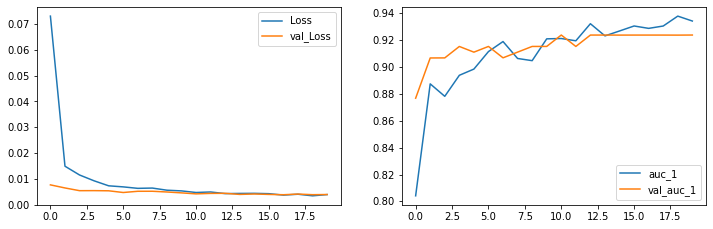

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(m.history['loss'], label='Loss')
plt.plot(m.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(m.history['auc_1'], label='auc_1')
plt.plot(m.history['val_auc_1'], label='val_auc_1')
plt.legend()